In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

Cгенерирую данные для расчета:

In [3]:
np.random.seed(42)
n_customers = 1000
n_months = 12
start_date = datetime(2024, 1, 1)

customers_data = []
for i in range(n_customers):
    acquisition_date = start_date + timedelta(days=np.random.randint(0, 365))
    acquisition_channel = np.random.choice(['SEO', 'PPC', 'Social', 'Email', 'Direct'])
    acquisition_cost = np.random.uniform(50, 200)  # CAC
    
    customers_data.append({
        'customer_id': 1000 + i,
        'acquisition_date': acquisition_date,
        'acquisition_channel': acquisition_channel,
        'acquisition_cost': acquisition_cost
    })

customers_df = pd.DataFrame(customers_data)

transactions_data = []
for customer in customers_data:
    customer_id = customer['customer_id']
    acquisition_date = customer['acquisition_date']
    
    
    n_orders = np.random.poisson(3) + 1  
    order_dates = [acquisition_date + timedelta(days=np.random.randint(0, 365)) 
                  for _ in range(n_orders)]
    order_dates.sort()
    
    for order_date in order_dates:
        order_value = np.random.lognormal(mean=5.5, sigma=0.8)  
        order_cost = order_value * np.random.uniform(0.4, 0.7)  
        margin = order_value - order_cost
        
        transactions_data.append({
            'customer_id': customer_id,
            'order_date': order_date,
            'order_value': round(order_value, 2),
            'order_cost': round(order_cost, 2),
            'order_margin': round(margin, 2)
        })

transactions_df = pd.DataFrame(transactions_data)
transactions_df['order_date'] = pd.to_datetime(transactions_df['order_date'])

print("Данные сгенерированы:")
print(f"Клиентов: {len(customers_df)}")
print(f"Транзакций: {len(transactions_df)}")
print(f"Период: {transactions_df['order_date'].min()} - {transactions_df['order_date'].max()}")

Данные сгенерированы:
Клиентов: 1000
Транзакций: 3985
Период: 2024-01-04 00:00:00 - 2025-12-27 00:00:00


Средний чек: 333.10 руб.
Средняя маржа: 150.08 руб.

CAC по каналам:
  Direct: 127.94 руб.
  Email: 124.55 руб.
  PPC: 124.81 руб.
  SEO: 123.50 руб.
  Social: 127.96 руб.


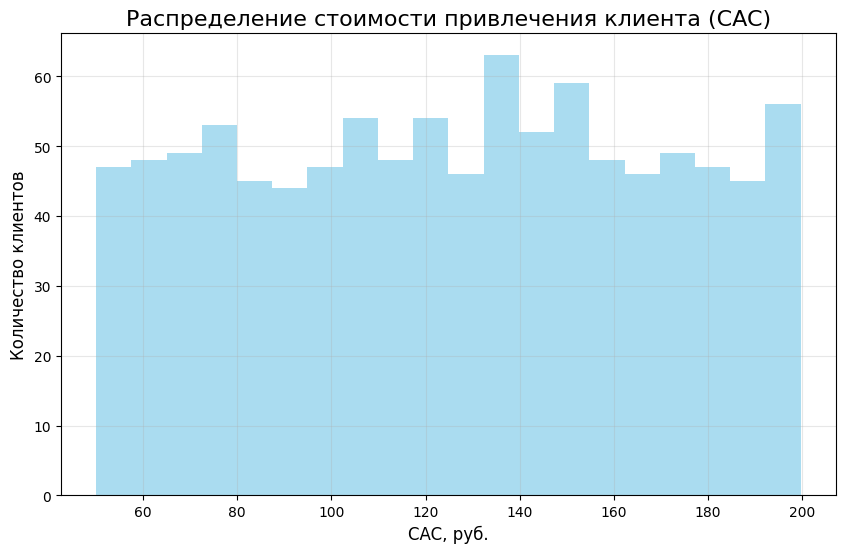

In [4]:
merged_df = pd.merge(transactions_df, customers_df, on='customer_id')

avg_order_value = merged_df['order_value'].mean()
print(f"Средний чек: {avg_order_value:.2f} руб.")

avg_margin = merged_df['order_margin'].mean()
print(f"Средняя маржа: {avg_margin:.2f} руб.")

cac_by_channel = customers_df.groupby('acquisition_channel')['acquisition_cost'].mean()
print("\nCAC по каналам:")
for channel, cac in cac_by_channel.items():
    print(f"  {channel}: {cac:.2f} руб.")

plt.figure(figsize=(10, 6))
plt.hist(customers_df['acquisition_cost'], bins=20, alpha=0.7, color='skyblue')
plt.title('Распределение стоимости привлечения клиента (CAC)', fontsize=16)
plt.xlabel('CAC, руб.', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

РАСЧЕТ LTV:
Средний LTV (выручка): 1327.40 руб.
Средний LTV (маржа): 598.08 руб.
Среднее время жизни: 198.2 дней
Средний ROI: 451.0%


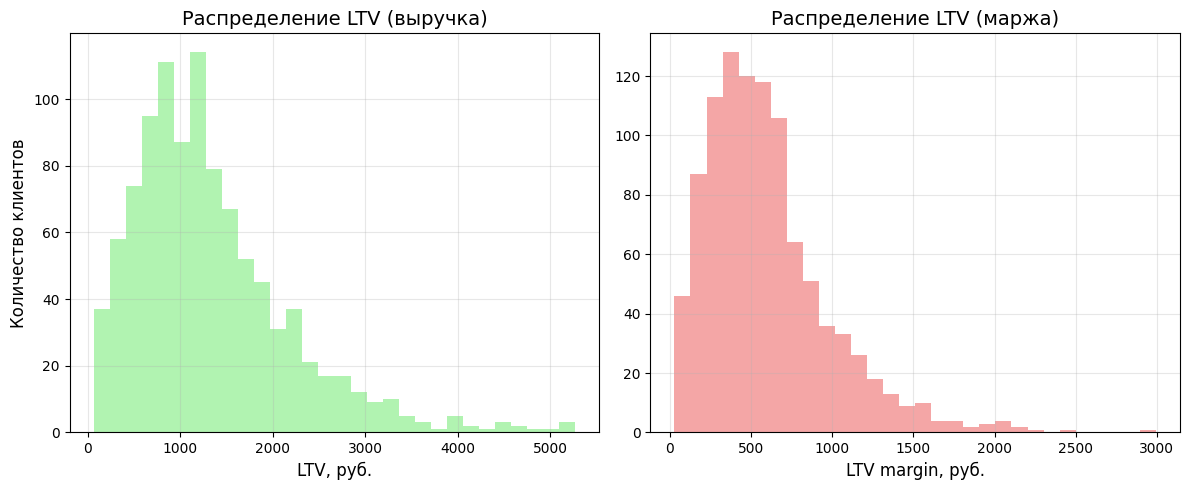

In [5]:
customer_ltv = merged_df.groupby('customer_id').agg({
    'order_value': 'sum',
    'order_margin': 'sum',
    'acquisition_cost': 'first'
}).reset_index()

customer_ltv.rename(columns={
    'order_value': 'total_revenue',
    'order_margin': 'total_margin'
}, inplace=True)

customer_lifetime = merged_df.groupby('customer_id')['order_date'].agg(['min', 'max']).reset_index()
customer_lifetime['lifetime_days'] = (customer_lifetime['max'] - customer_lifetime['min']).dt.days + 1

customer_ltv = pd.merge(customer_ltv, customer_lifetime[['customer_id', 'lifetime_days']], on='customer_id')

customer_ltv['roi'] = (customer_ltv['total_margin'] - customer_ltv['acquisition_cost']) / customer_ltv['acquisition_cost'] * 100

print("РАСЧЕТ LTV:")
print("=" * 50)
print(f"Средний LTV (выручка): {customer_ltv['total_revenue'].mean():.2f} руб.")
print(f"Средний LTV (маржа): {customer_ltv['total_margin'].mean():.2f} руб.")
print(f"Среднее время жизни: {customer_ltv['lifetime_days'].mean():.1f} дней")
print(f"Средний ROI: {customer_ltv['roi'].mean():.1f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(customer_ltv['total_revenue'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Распределение LTV (выручка)', fontsize=14)
plt.xlabel('LTV, руб.', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(customer_ltv['total_margin'], bins=30, alpha=0.7, color='lightcoral')
plt.title('Распределение LTV (маржа)', fontsize=14)
plt.xlabel('LTV margin, руб.', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

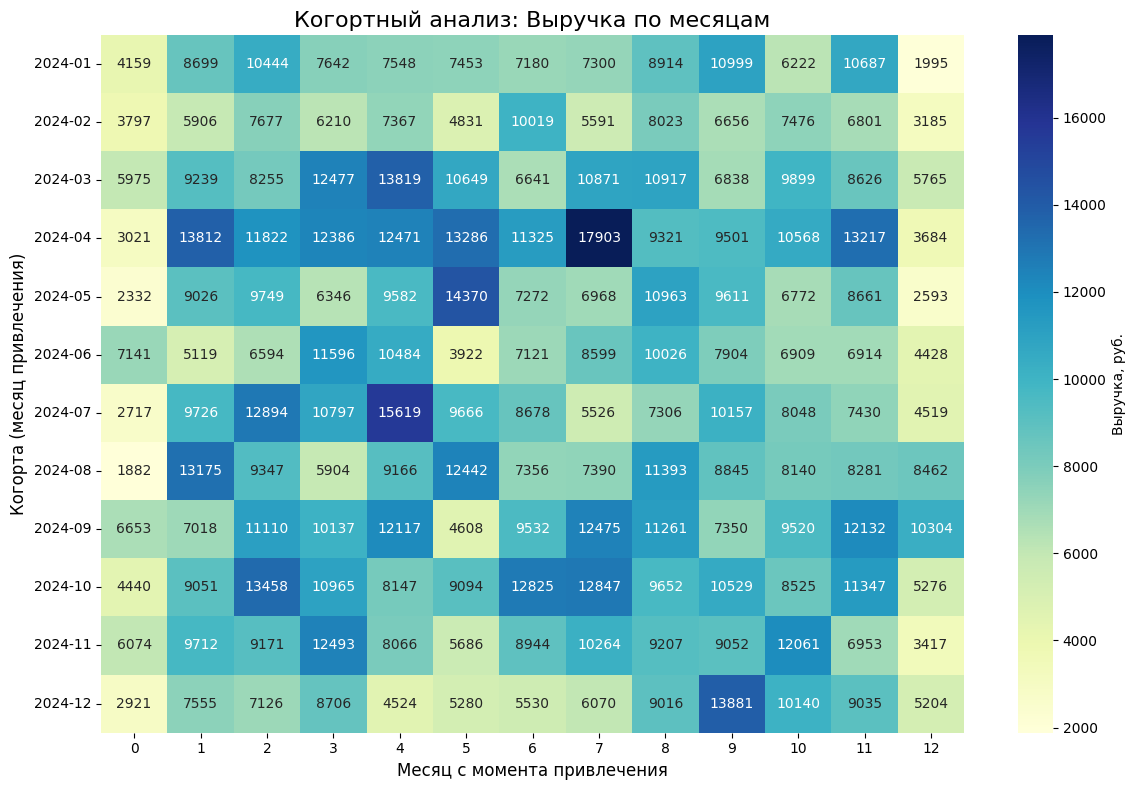

In [6]:

merged_df['acquisition_month'] = merged_df['acquisition_date'].dt.to_period('M')
merged_df['order_month'] = merged_df['order_date'].dt.to_period('M')

cohort_analysis = merged_df.groupby(['acquisition_month', 'order_month']).agg({
    'customer_id': 'nunique',
    'order_value': 'sum',
    'order_margin': 'sum'
}).reset_index()

cohort_analysis['months_since_acquisition'] = (cohort_analysis['order_month'] - cohort_analysis['acquisition_month']).apply(lambda x: x.n)

cohort_pivot = cohort_analysis.pivot_table(
    index='acquisition_month', 
    columns='months_since_acquisition', 
    values='order_value', 
    aggfunc='sum'
)

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', 
            cbar_kws={'label': 'Выручка, руб.'})
plt.title('Когортный анализ: Выручка по месяцам', fontsize=16)
plt.xlabel('Месяц с момента привлечения', fontsize=12)
plt.ylabel('Когорта (месяц привлечения)', fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
avg_cac = customers_df['acquisition_cost'].mean()
avg_ltv_revenue = customer_ltv['total_revenue'].mean()
avg_ltv_margin = customer_ltv['total_margin'].mean()

ltv_cac_ratio = avg_ltv_margin / avg_cac
payback_period = avg_cac / (avg_ltv_margin / (customer_ltv['lifetime_days'].mean() / 30))  # в месяцах

print(f"Средний CAC: {avg_cac:.2f} руб.")
print(f"Средний LTV (выручка): {avg_ltv_revenue:.2f} руб.")
print(f"Средний LTV (маржа): {avg_ltv_margin:.2f} руб.")
print(f"Соотношение LTV/CAC: {ltv_cac_ratio:.2f}")
print(f"Окупаемость CAC: {payback_period:.1f} месяцев")

channel_economics = merged_df.groupby('acquisition_channel').agg({
    'customer_id': 'nunique',
    'acquisition_cost': 'mean',
    'order_value': 'sum',
    'order_margin': 'sum'
}).reset_index()

channel_economics['ltv_revenue'] = channel_economics['order_value'] / channel_economics['customer_id']
channel_economics['ltv_margin'] = channel_economics['order_margin'] / channel_economics['customer_id']
channel_economics['ltv_cac_ratio'] = channel_economics['ltv_margin'] / channel_economics['acquisition_cost']
channel_economics['roi'] = (channel_economics['order_margin'] - 
                           channel_economics['acquisition_cost'] * channel_economics['customer_id']) / \
                          (channel_economics['acquisition_cost'] * channel_economics['customer_id']) * 100

print("\nЭКОНОМИКА ПО КАНАЛАМ:")
print(channel_economics[['acquisition_channel', 'customer_id', 'acquisition_cost', 
                        'ltv_margin', 'ltv_cac_ratio', 'roi']].round(2))

Средний CAC: 125.78 руб.
Средний LTV (выручка): 1327.40 руб.
Средний LTV (маржа): 598.08 руб.
Соотношение LTV/CAC: 4.75
Окупаемость CAC: 1.4 месяцев

ЭКОНОМИКА ПО КАНАЛАМ:
  acquisition_channel  customer_id  acquisition_cost  ltv_margin  \
0              Direct          217            129.21      583.96   
1               Email          190            125.02      590.68   
2                 PPC          192            127.62      643.57   
3                 SEO          207            123.38      581.71   
4              Social          194            127.82      593.53   

   ltv_cac_ratio     roi  
0           4.52  351.94  
1           4.72  372.48  
2           5.04  404.29  
3           4.71  371.48  
4           4.64  364.34  


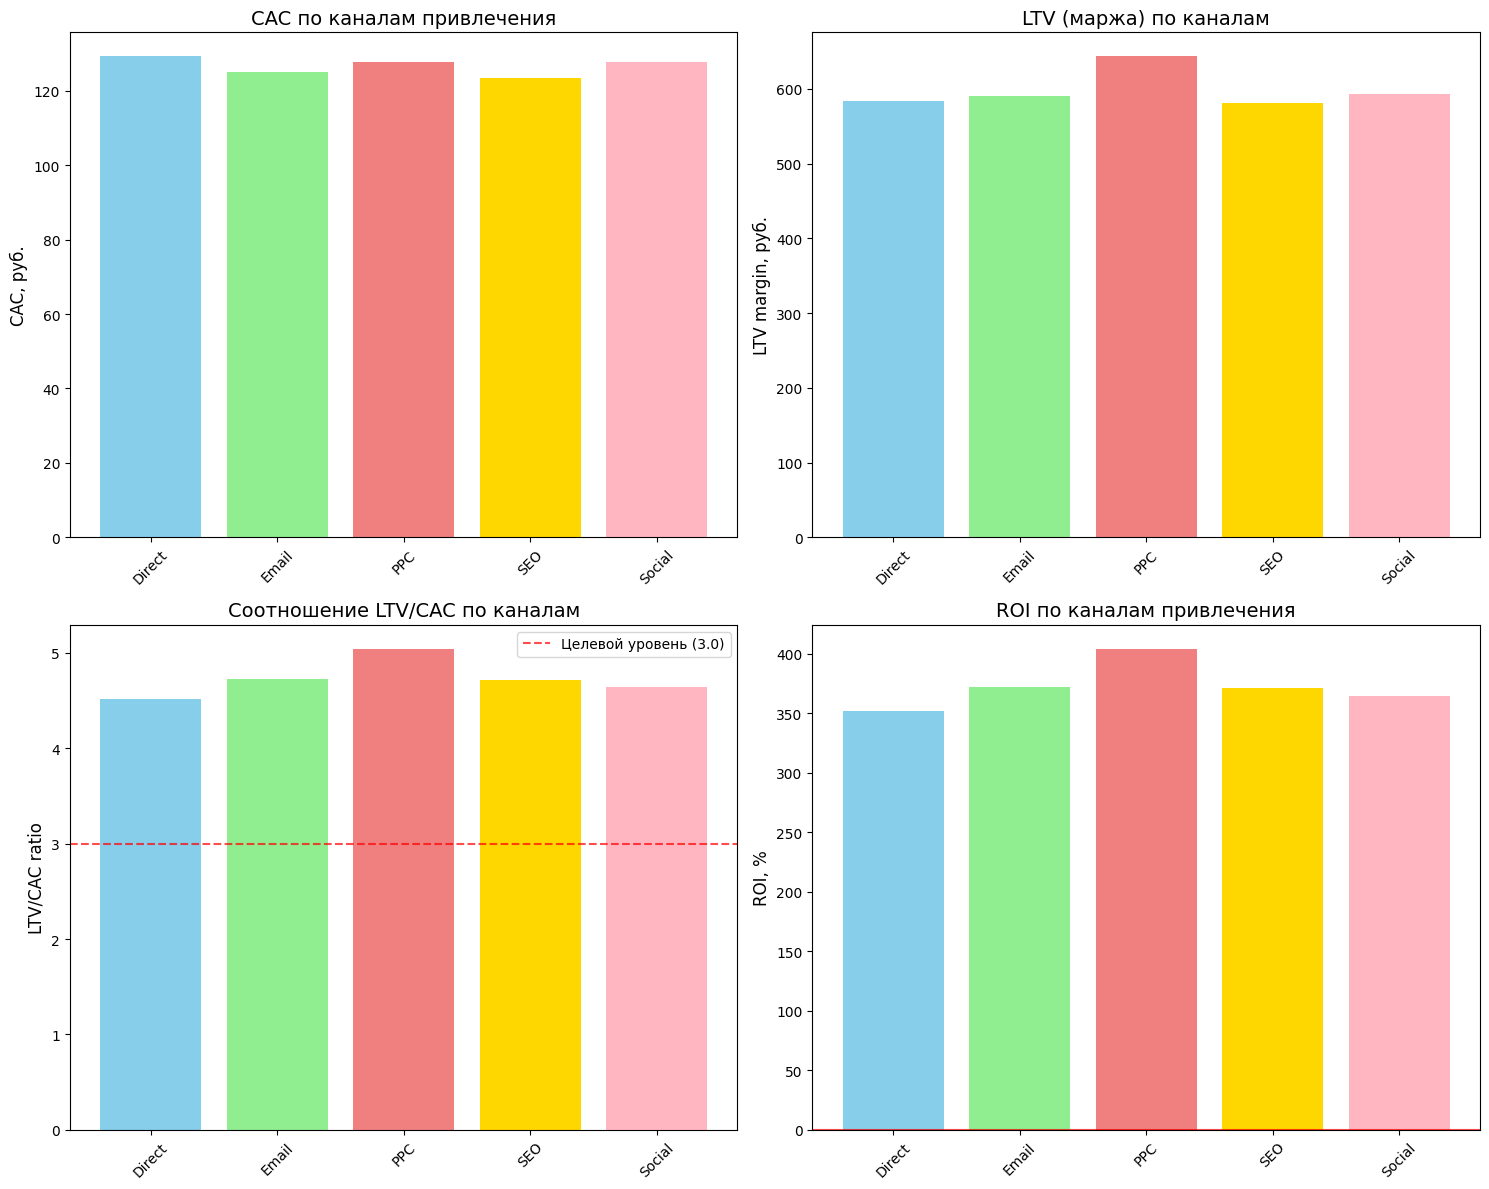

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(channel_economics['acquisition_channel'], channel_economics['acquisition_cost'],
              color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
axes[0, 0].set_title('CAC по каналам привлечения', fontsize=14)
axes[0, 0].set_ylabel('CAC, руб.', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(channel_economics['acquisition_channel'], channel_economics['ltv_margin'],
              color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
axes[0, 1].set_title('LTV (маржа) по каналам', fontsize=14)
axes[0, 1].set_ylabel('LTV margin, руб.', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(channel_economics['acquisition_channel'], channel_economics['ltv_cac_ratio'],
              color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
axes[1, 0].axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Целевой уровень (3.0)')
axes[1, 0].set_title('Соотношение LTV/CAC по каналам', fontsize=14)
axes[1, 0].set_ylabel('LTV/CAC ratio', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()

axes[1, 1].bar(channel_economics['acquisition_channel'], channel_economics['roi'],
              color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
axes[1, 1].axhline(y=0, color='red', linestyle='-', alpha=0.7)
axes[1, 1].set_title('ROI по каналам привлечения', fontsize=14)
axes[1, 1].set_ylabel('ROI, %', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
cac_scenarios = [avg_cac * factor for factor in [0.8, 1.0, 1.2, 1.5]]
ltv_cac_scenarios = [avg_ltv_margin / cac for cac in cac_scenarios]

print("Сценарии изменения CAC:")
for cac, ratio in zip(cac_scenarios, ltv_cac_scenarios):
    print(f"  CAC = {cac:.0f} руб.: LTV/CAC = {ratio:.2f}")

retention_rates = [0.1, 0.2, 0.3, 0.4]  
ltv_retention_scenarios = []
for retention in retention_rates:
    estimated_ltv = avg_order_value * 1.5 / (1 - retention)
    ltv_retention_scenarios.append(estimated_ltv)

print("\nСценарии изменения удержания:")
for retention, ltv in zip(retention_rates, ltv_retention_scenarios):
    print(f"  Retention = {retention*100:.0f}%: Estimated LTV = {ltv:.0f} руб.")

Сценарии изменения CAC:
  CAC = 101 руб.: LTV/CAC = 5.94
  CAC = 126 руб.: LTV/CAC = 4.75
  CAC = 151 руб.: LTV/CAC = 3.96
  CAC = 189 руб.: LTV/CAC = 3.17

Сценарии изменения удержания:
  Retention = 10%: Estimated LTV = 555 руб.
  Retention = 20%: Estimated LTV = 625 руб.
  Retention = 30%: Estimated LTV = 714 руб.
  Retention = 40%: Estimated LTV = 833 руб.


In [12]:
best_channel = channel_economics.loc[channel_economics['roi'].idxmax()]
worst_channel = channel_economics.loc[channel_economics['roi'].idxmin()]

print(f"1. САМЫЙ ЭФФЕКТИВНЫЙ КАНАЛ: {best_channel['acquisition_channel']}")
print(f"   - ROI: {best_channel['roi']:.1f}%")
print(f"   - LTV/CAC: {best_channel['ltv_cac_ratio']:.2f}")
print(f"   - Рекомендация: Увеличить инвестиции в этот канал")

print(f"\n2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ КАНАЛ: {worst_channel['acquisition_channel']}")
print(f"   - ROI: {worst_channel['roi']:.1f}%")
print(f"   - LTV/CAC: {worst_channel['ltv_cac_ratio']:.2f}")
print(f"   - Рекомендация: Оптимизировать или сократить инвестиции")

print(f"\n3. ОБЩИЕ РЕКОМЕНДАЦИИ:")
if ltv_cac_ratio < 3:
    print("     LTV/CAC ratio ниже целевого уровня 3.0")
    print("    Фокус на увеличении LTV или снижении CAC")
else:
    print("    LTV/CAC ratio на хорошем уровне")
    print("    Можно масштабировать привлечение")

if payback_period > 6:
    print("     Долгий срок окупаемости (>6 месяцев)")
    print("    Работать над увеличением частоты покупок")
else:
    print("    Хороший срок окупаемости")

print(f"\n4. КЛЮЧЕВЫЕ МЕТРИКИ:")
print(f"    CAC: {avg_cac:.0f} руб.")
print(f"    LTV: {avg_ltv_margin:.0f} руб.")
print(f"     LTV/CAC: {ltv_cac_ratio:.2f}")
print(f"     Окупаемость: {payback_period:.1f} мес.")
print(f"    ROI: {customer_ltv['roi'].mean():.1f}%")

print(f"\n5. ПРИОРИТЕТЫ НА БЛИЖАЙШИЙ ПЕРИОД:")
priorities = [
    "1. Оптимизация CAC в неэффективных каналах",
    "2. Увеличение среднего чека и частоты покупок",
    "3. Улучшение удержания клиентов",
    "4. A/B тестирование ценовой стратегии",
    "5. Внедрение программ лояльности"
]

for priority in priorities:
    print(f"   {priority}")

1. САМЫЙ ЭФФЕКТИВНЫЙ КАНАЛ: PPC
   - ROI: 404.3%
   - LTV/CAC: 5.04
   - Рекомендация: Увеличить инвестиции в этот канал

2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ КАНАЛ: Direct
   - ROI: 351.9%
   - LTV/CAC: 4.52
   - Рекомендация: Оптимизировать или сократить инвестиции

3. ОБЩИЕ РЕКОМЕНДАЦИИ:
    LTV/CAC ratio на хорошем уровне
    Можно масштабировать привлечение
    Хороший срок окупаемости

4. КЛЮЧЕВЫЕ МЕТРИКИ:
    CAC: 126 руб.
    LTV: 598 руб.
     LTV/CAC: 4.75
     Окупаемость: 1.4 мес.
    ROI: 451.0%

5. ПРИОРИТЕТЫ НА БЛИЖАЙШИЙ ПЕРИОД:
   1. Оптимизация CAC в неэффективных каналах
   2. Увеличение среднего чека и частоты покупок
   3. Улучшение удержания клиентов
   4. A/B тестирование ценовой стратегии
   5. Внедрение программ лояльности
